# ROI GLMs

In [1]:
import nideconv
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
# from jupyterthemes import jtplot
# jtplot.style('onedork')

import sys
import os
import pickle as pkl

import glob
import re

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Statistics
from scipy import stats
from statsmodels.sandbox.stats import multicomp

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling 

## Utility functions

In [2]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    if session in ['optcomb', 'me', 'PAID', 'echo_1', 'echo_2', 'echo_3', 'me-den']:
        session = 'me'
    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    if event_types is not None:
        to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)
    else:
        to_return = df

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def get_all_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat

def get_session_timeseries(ses, standardize='zscore', override_runs=None, drop_label=True):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            ts = get_all_ts(sub, ses, run)
            
            # set on common scale across runs
            if standardize == 'psc':
                ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
            elif standardize == 'zscore':
                ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub
            ts['run'] = run
            if drop_label:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop', 'response_left', 'response_right')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)

        for run in runs:
            onsets_this_run = get_event_data(sub, ses, run, event_types=event_types)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run', 'trial_type', 'onset', 'duration', 'response_time']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [3]:
def plot_single_mask_timecourses(rfGroup, data_type,
                                 mask_name, oversample=100, plot_type='first_level',
                                 event_types=('go_trial', 'failed_stop', 'successful_stop'),
                                 ax=None, legend='brief', add_sigma2=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
        
    if data_type == 't':
        ## plot t-values
        if rfGroup.concatenate_runs:
            rfs = rfGroup._get_response_fitters(concatenate_runs=True)
            t_ = rfs.apply(lambda rf: rf.get_t_value_timecourses(oversample))
            t = pd.concat(t_.to_dict())
            index_names = t_.index.names
            t.index.set_names(index_names, level=range(len(index_names)), inplace=True)
            tc_3 = t['t'].reset_index()[['subject', 'event type', 'time', mask_name]]
            
        else:
            tc = rfGroup.get_t_value_timecourses(oversample=oversample, concatenate_runs=rfGroup.concatenate_runs).t
            tc = tc[mask_name].reset_index()

            # mean over runs
            tc_2 = tc.reset_index().rename(columns={"level_0": 'subject', 'level_1': 'session', 'level_2': 'run'})
            tc_3 = tc_2.pivot_table(values=mask_name, index=['subject', 'session', 'event type', 'time']).reset_index()
        sns.lineplot(x='time', y=mask_name, hue='event type', hue_order=event_types, data=tc_3, legend=legend, ax=ax,
                     ci=67)
    elif data_type == 'psc':
        ## plot psc or z-scores
#        group_rf = rfGroup[data_type]
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        
        if plot_type == 'first_level':
            tc = tc.loc[np.in1d(tc['event type'], event_types)]
            
            sns.lineplot(x='time', y='value', hue='event type', hue_order=event_types, 
                         data=tc.loc[tc['roi']==mask_name], 
                         legend=legend, ax=ax, ci=67)

#             sns.tsplot(data=tc.loc[tc['roi']==mask_name], 
#                        time='time', unit='subject', 
#                        condition='event type', value='value', 
#                        ax=ax, legend=legend)
        else:
            tc = tc.loc[tc.roi==mask_name]
            tc = tc.loc[np.in1d(tc['event type'], ('go_trial', 'failed_stop', 'successful_stop'))]
            tc = tc.pivot_table(values='value', index=['subject', 'time', 'covariate'], columns='event type').reset_index()
            tc['failed_stop - go_trial'] = tc['failed_stop'] - tc['go_trial']
            tc['failed_stop - successful_stop'] = tc['failed_stop'] - tc['successful_stop']
            tc['successful_stop - go_trial'] = tc['successful_stop'] - tc['go_trial']
            tc = tc.melt(id_vars=['subject', 'time'], value_vars=['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])
            sns.lineplot(x='time', y='value', hue='event type', data=tc, legend=legend, ax=ax)
    elif data_type == 't-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        t_vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: stats.ttest_1samp(x, 0)[0]).reset_index()
        sns.lineplot(data=t_vals.loc[t_vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend)
    elif data_type == 'snr-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: x.mean()/x.std()).reset_index()
        sns.lineplot(data=vals.loc[vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend, hue_order=event_types)
    
    if add_sigma2:
        sigma2 = rfGroup._get_response_fitters().apply(lambda x: x.sigma2)[mask_name]
        t = ax.text(.95, .95, '$\sigma^2 = {}\pm{}$'.format(np.mean(sigma2).round(2), np.std(sigma2).round(2)),
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='grey'))
        
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    
from matplotlib import gridspec
    
def make_plot(plot_dict, data_type, columns, masks, oversample=100, plot_type='first_level', 
              y_label='% signal change', event_types=('failed_stop', 'go_trial', 'successful_stop'),
              column_titles=None, add_sigma2=False, sharey='row'):
    
    if len(columns) == 5 and not sharey == 'row':
        width_ratios = [1, 0.1, 1, 0.3, 1, .1, 1, .1, 1]
    else:
        width_ratios = [1, .15] * (len(columns)-1) + [1]
    gridspec_kws = dict(hspace=0.1, wspace=0.0, 
                        width_ratios=width_ratios)
    f, axes = plt.subplots(len(masks), len(width_ratios), gridspec_kw=gridspec_kws)

    columns_to_populate = np.arange(len(columns), dtype=int)*2
    empty_columns = [x for x in np.arange(len(width_ratios)) if not x in columns_to_populate]
    for col in empty_columns:
        for row in range(len(masks)):
            axes[row, col].axis('off')
    
#     f, axes = plt.subplots(len(masks), len(columns))
    if len(axes.shape) == 1:
        axes = axes[np.newaxis,:]

#     ax = f.add_subplot(111, frameon=False)
#     # hide tick and tick label of the big axes
# #     ax.axis('off')
#     ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
#     ax.spines["left"].set_visible(False)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.set_ylabel(y_label)
#     # ax.set_xlabel('Time from trial onset (s)')
#     ax.yaxis.labelpad = 30
#    fig.text(0.5, 0.04, 'common X', ha='center')
    f.text(0.05, 0.5, y_label, va='center', rotation='vertical')#, labelpad=30)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    # loop over the columns (j) and rows(i) to populate subplots
    for j in range(len(axes[0,:])):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[columns_to_populate.max()][0]+ext[columns_to_populate.max()][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .1, "Time from trial onset (s)", va="center", ha="center")

    # plot
    for row, mask in enumerate(masks):
        print(mask, end='')
        for col_n, session_name in zip(columns_to_populate, columns):
    
            if isinstance(oversample, list):
                oversample_ = oversample[col_n]
            else:
                oversample_ = oversample
            print('.', end='')
            plot_single_mask_timecourses(plot_dict[session_name],
                                         data_type=data_type,
                                         mask_name=mask, 
                                         ax=axes[row,col_n], 
                                         plot_type=plot_type,
                                         oversample=oversample_,
                                         event_types=event_types,
                                         add_sigma2=add_sigma2)
            if col_n > 0:
                axes[row, col_n].set_ylabel('')
            # remove xlabels except bottom row
#             if row < (len(masks)-1):
            axes[row, col_n].set_xlabel('')
        axes[row,0].set_ylabel(mask)

        if sharey == 'row':
            # get maximum ylims, set
            current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row,:]])
            for ax in axes[row,:]:
                ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])
        else:
            for sharey_columns in sharey:
                sharey_columns = [x*2 for x in sharey_columns]
                # get maximum ylims, set
                current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, sharey_columns]])
                for ax in axes[row, sharey_columns]:
                    ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

    # Add column titles
    if column_titles is None:
        column_titles = columns
    
    for col_n, col_name in zip(columns_to_populate, column_titles):
        axes[0, col_n].set_title(col_name.replace('_', ' '))

    if plot_type == 'contrasts':
        labels = ["Failed stop - go", "Failed stop - successful stop", "Successful stop - go"]
    else:
        labels = ['Failed stop', 'Go', 'Successful stop']
        
    # remove legends except first
    for row_n in range(len(masks)):
        for col_n in columns_to_populate:
            if col_n == 4 and row_n == 0:
                axes[row_n, col_n].legend(handles=axes[row_n, col_n].lines, 
                                          labels=labels,
                                          loc=9, ncol=3, bbox_to_anchor=(.5, 1.4))
#                 axes[row_n, col_n].legend_.set_bbox_to_anchor((1, 1), transform=axes[row_n, col_n].transAxes)
            else:
                axes[row_n, col_n].legend_.remove()
    
    # determine where to place/remove ticks on y-axis
    if sharey == 'row':
        keep_y_ticks = [0]
    else:
        keep_y_ticks = [x[0]*2 for x in sharey]
        
    # hide ticks/values on axes
    for col in np.arange(1, columns_to_populate.max()+1):
        if col in keep_y_ticks:
            labelleft = 'On'
        else:
            labelleft = 'Off'

        for row in range(0, len(masks)-1):
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off', labelleft=labelleft)

        # for bottom row, keep bottom labels
        axes[len(masks)-1,col].tick_params(top='off', right='off', labelleft=labelleft)

    for row in range(0, len(masks)-1):
#        axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
        for col in keep_y_ticks:
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off')
    

    f.set_size_inches(len(columns)*4, len(masks)*3)
    return f, axes

In [4]:
ses_ts = {'se': {'psc': get_session_timeseries('se', standardize='psc'),
                 'zscore': get_session_timeseries('se', standardize='zscore')},
          'optcomb': {'psc': get_session_timeseries('optcomb', standardize='psc'),
                      'zscore': get_session_timeseries('optcomb', standardize='zscore')},
          'echo_1': {'psc': get_session_timeseries('echo_1', standardize='psc'),
                     'zscore': get_session_timeseries('echo_1', standardize='zscore')},
          'echo_2': {'psc': get_session_timeseries('echo_2', standardize='psc'),
                     'zscore': get_session_timeseries('echo_2', standardize='zscore')},
          'echo_3': {'psc': get_session_timeseries('echo_3', standardize='psc'),
                     'zscore': get_session_timeseries('echo_3', standardize='zscore')}}


## Fit canonical HRF with temporal derivative

In [5]:
# get motion parameters as confounds
def get_confounds_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
            
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

In [15]:
##### TMP: use OLS

rfGroupsCwD_ols = {'psc': {}} #, 'zscore': {}}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    for standardization in rfGroupsCwD.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = ses_ts[ses][standardization]
        confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
        confounds = confounds.reset_index()
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                               oversample_design_matrix=20)
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative')
        rfGroup.fit(store_residuals=True, type='ols')

        rfGroupsCwD_ols[standardization][ses] = rfGroup

Data: se...psc...

Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

In [6]:
##
#masks = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'lGPe', 'rGPe', 'lPreSMA', 'rPreSMA', 'rM1', 'rIFG']


rfGroupsCwD = {'psc': {}} #, 'zscore': {}}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    for standardization in rfGroupsCwD.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = ses_ts[ses][standardization]
        confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
        confounds = confounds.reset_index()
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                               oversample_design_matrix=20)
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative')
        rfGroup.fit(store_residuals=True, type='ar(1)')

        rfGroupsCwD[standardization][ses] = rfGroup

Data: se...psc...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

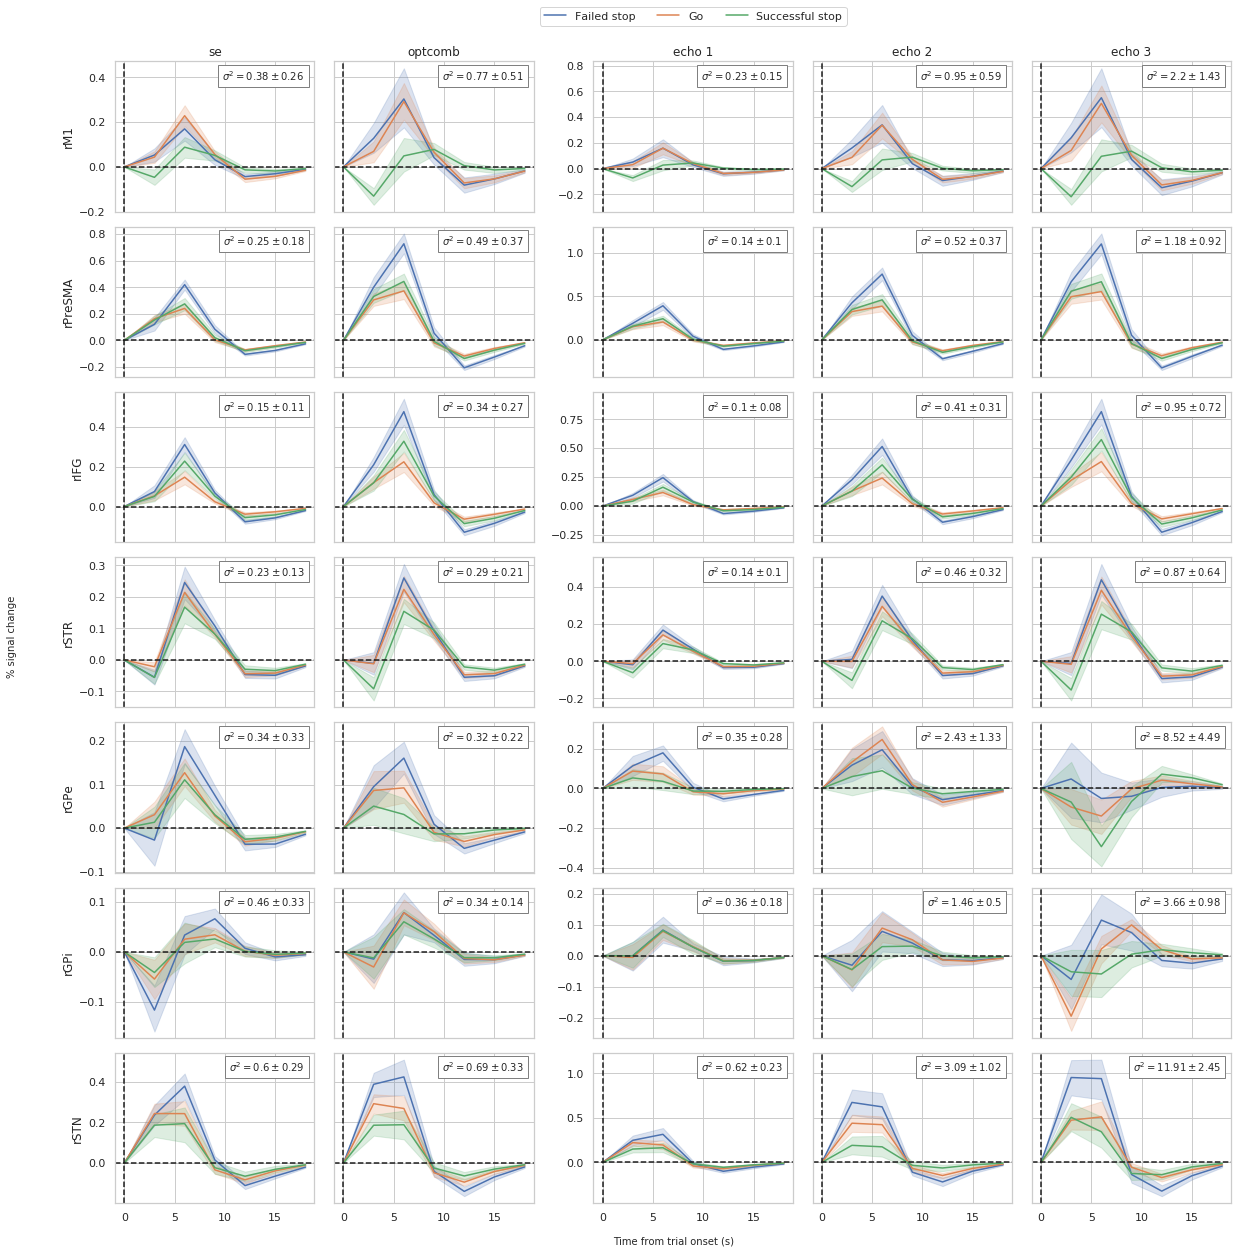

In [7]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

f, ax = make_plot(plot_dict=rfGroupsCwD['psc'],
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='psc', 
                  oversample=1,
                  plot_type='first_level',
                  add_sigma2=True,
                  sharey=[(0, 1), (2, 3, 4)])

# Comparison of first-level $t$-values between protocols

In [11]:
import statsmodels.api as sm
import scipy as sp

def get_t_vals(rfGroup, data_type='se', contrast_type='first_level'):
    """ Extract t-values (PEs, PE variance) from rfGroup-object """
    contrasts = {}
    
    # Get regressor names, construct contrast vector
    X = rfGroup._get_response_fitters()[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    successful_stop_vs_baseline = (regressor_names == 'successful_stop_intercept_canonical_hrf').astype(int)
    failed_stop_vs_baseline = (regressor_names == 'failed_stop_intercept_canonical_hrf').astype(int)
    go_trial_vs_baseline = (regressor_names == 'go_trial_intercept_canonical_hrf').astype(int)
    
    if contrast_type == 'first_level':
        contrasts['Successful stop'] = successful_stop_vs_baseline
        contrasts['Failed stop'] = failed_stop_vs_baseline
        contrasts['Go'] = go_trial_vs_baseline
    else:
        contrasts['Failed stop - go'] = failed_stop_vs_baseline - go_trial_vs_baseline
        contrasts['Failed stop - successful stop'] = failed_stop_vs_baseline - successful_stop_vs_baseline
        contrasts['Successful stop - go'] = successful_stop_vs_baseline - go_trial_vs_baseline
    from pprint import pprint
    pprint(contrasts)

#         if data_type == 'se':
#             contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
#             contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
#             contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
#         else:
#             contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
#             contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
#             contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
#     else:
#         if data_type == 'se':
#             contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  0, 0, 1, 0]
#             contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, -1, 0, 1, 0]
#             contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  1, 0, 0, 0]
#         else:
#             contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,  0, 0]
#             contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, -1, 0]
#             contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,  1, 0]

    pes = []
    var_pes = []
    ts = []
    for c_name, c_vector in contrasts.items():
        pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='cope'))
        var_pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='varcope'))
        t = pe / np.sqrt(var_pe)
        
        pe['Event'] = c_name
        var_pe['Event'] = c_name
        t['Event'] = c_name
        
        pes.append(pe)
        var_pes.append(var_pe)
        ts.append(t)

    return pd.concat(pes), pd.concat(var_pes), pd.concat(ts)
    
def estimate_contrast(response_fitter, C, return_type='cope'):
    X = response_fitter.X
    ys = response_fitter.input_signal
    all_copes = []
    all_varcopes = []
    if ys.shape[1] > 1:
        for roi_idx, roi in enumerate(ys.columns):
#             print(roi)
            this_gls = response_fitter.gls_models[roi_idx]
            this_gls_res = response_fitter.gls_results[roi_idx]
            this_sigma2 = response_fitter
#             this_y = ys[roi].copy()
#             this_X = X.copy()
#             ols_resid = sm.OLS(this_y, this_X).fit().resid.values
#             resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
#             rho = resid_fit.params[1]  # this is our rho

#             # make V
#             order = sp.linalg.toeplitz(np.arange(len(this_y)))
#             V = rho ** order

#             gls = sm.GLS(this_y, this_X, sigma=V)
#             gls_res = gls.fit()
            
            # prewhitened design variance
            wX = this_gls.wexog
            XtXinv = np.linalg.pinv(np.dot(wX.T, wX))
            
            # error variance
            sigma2 = response_fitter.sigma2.values[roi_idx]
            
            # contrast
            cope = np.dot(C, this_gls_res.params)
            varcope = sigma2*np.dot(np.dot(C, XtXinv), C)
            

            all_copes.append(cope)
            all_varcopes.append(varcope)
            
            
            ## manually below
#             W = np.linalg.cholesky(np.linalg.pinv(V))

#             # whiten
#             this_X_w = np.dot(W, this_X)
#             this_y_w = np.dot(W, this_y)

#             # pes
#             XtXinv = np.linalg.pinv(np.dot(this_X_w.T, this_X_w))
#             XY = np.dot(this_X_w.T, this_y_w)
#             betas = np.dot(XtXinv, XY)

#             # copes
#             copes = np.dot(C, betas)

#             # var; get sigma^2 of the model
#             pred = this_X_w.dot(betas)
#             resid = this_y_w - pred

            # variance
#            XtXinv = np.linalg.pinv(np.dot(wX.T, wX))
#            e = this_y - gls_res.predict()
#            sigma2 = (np.dot(e.T, e)).sum()/(this_y.shape[0]-(this_X.shape[1]))
            #(np.dot(e.T, e)).sum()/(this_y.shape[0]-(this_X.shape[1]))  # sum of squared errors / (T - p)
#            varcope = sigma2*np.dot(np.dot(C, XtXinv), C)

#             varcope = sigma2*np.dot(np.dot(C, XtXinv), C)

#             all_copes.append(copes)
#             all_varcopes.append(varcope)
    if return_type == 'cope':
        return pd.Series(all_copes, index=ys.columns)
    elif return_type == 'varcope':
        return pd.Series(all_varcopes, index=ys.columns)

In [12]:
# get first-level t-values for the single echo, optimally combined multi echo data, and per echo
pe_se, var_se, t_se = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se')
pe_oc, var_oc, t_oc = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc')
pe_e1, var_e1, t_e1 = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1')
pe_e2, var_e2, t_e2 = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2')
pe_e3, var_e3, t_e3 = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3')

# Add name to data frames
t_se['Data'] = 'Single echo'
t_oc['Data'] = 'Multi echo (OC)'
t_e1['Data'] = 'Echo 1'
t_e2['Data'] = 'Echo 2'
t_e3['Data'] = 'Echo 3'

pe_se['Data'] = 'Single echo'
pe_oc['Data'] = 'Multi echo (OC)'
pe_e1['Data'] = 'Echo 1'
pe_e2['Data'] = 'Echo 2'
pe_e3['Data'] = 'Echo 3'

# Add contrasts
pe_se_contrast, var_se_contrast, t_se_contrast = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se', contrast_type='contrast')
pe_oc_contrast, var_oc_contrast, t_oc_contrast = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc', contrast_type='contrast')
pe_e1_contrast, var_e1_contrast, t_e1_contrast = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1', contrast_type='contrast')
pe_e2_contrast, var_e2_contrast, t_e2_contrast = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2', contrast_type='contrast')
pe_e3_contrast, var_e3_contrast, t_e3_contrast = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3', contrast_type='contrast')

t_se_contrast['Data'] = 'Single echo'
t_oc_contrast['Data'] = 'Multi echo (OC)'
t_e1_contrast['Data'] = 'Echo 1'
t_e2_contrast['Data'] = 'Echo 2'
t_e3_contrast['Data'] = 'Echo 3'

pe_se_contrast['Data'] = 'Single echo'
pe_oc_contrast['Data'] = 'Multi echo (OC)'
pe_e1_contrast['Data'] = 'Echo 1'
pe_e2_contrast['Data'] = 'Echo 2'
pe_e3_contrast['Data'] = 'Echo 3'

# Concatenate everything into pd.DataFrames
pes = pd.concat([pe_se, pe_oc, pe_e1, pe_e2, pe_e3, pe_se_contrast, pe_oc_contrast, pe_e1_contrast, pe_e2_contrast, pe_e3_contrast])
t_vals = pd.concat([t_se, t_oc, t_e1, t_e2, t_e3, t_se_contrast, t_oc_contrast, t_e1_contrast, t_e2_contrast, t_e3_contrast])

# Make them "long" instead of "wide"
pes_long = pes.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='pe')
t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t')

pes_long.head()

{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop - go':

,subject,Data,Event,ROI,pe
0,01,Single echo,Successful stop,ACC,0.062761
1,02,Single echo,Successful stop,ACC,0.265772
2,03,Single echo,Successful stop,ACC,0.352048
3,04,Single echo,Successful stop,ACC,0.082320
4,05,Single echo,Successful stop,ACC,0.426828


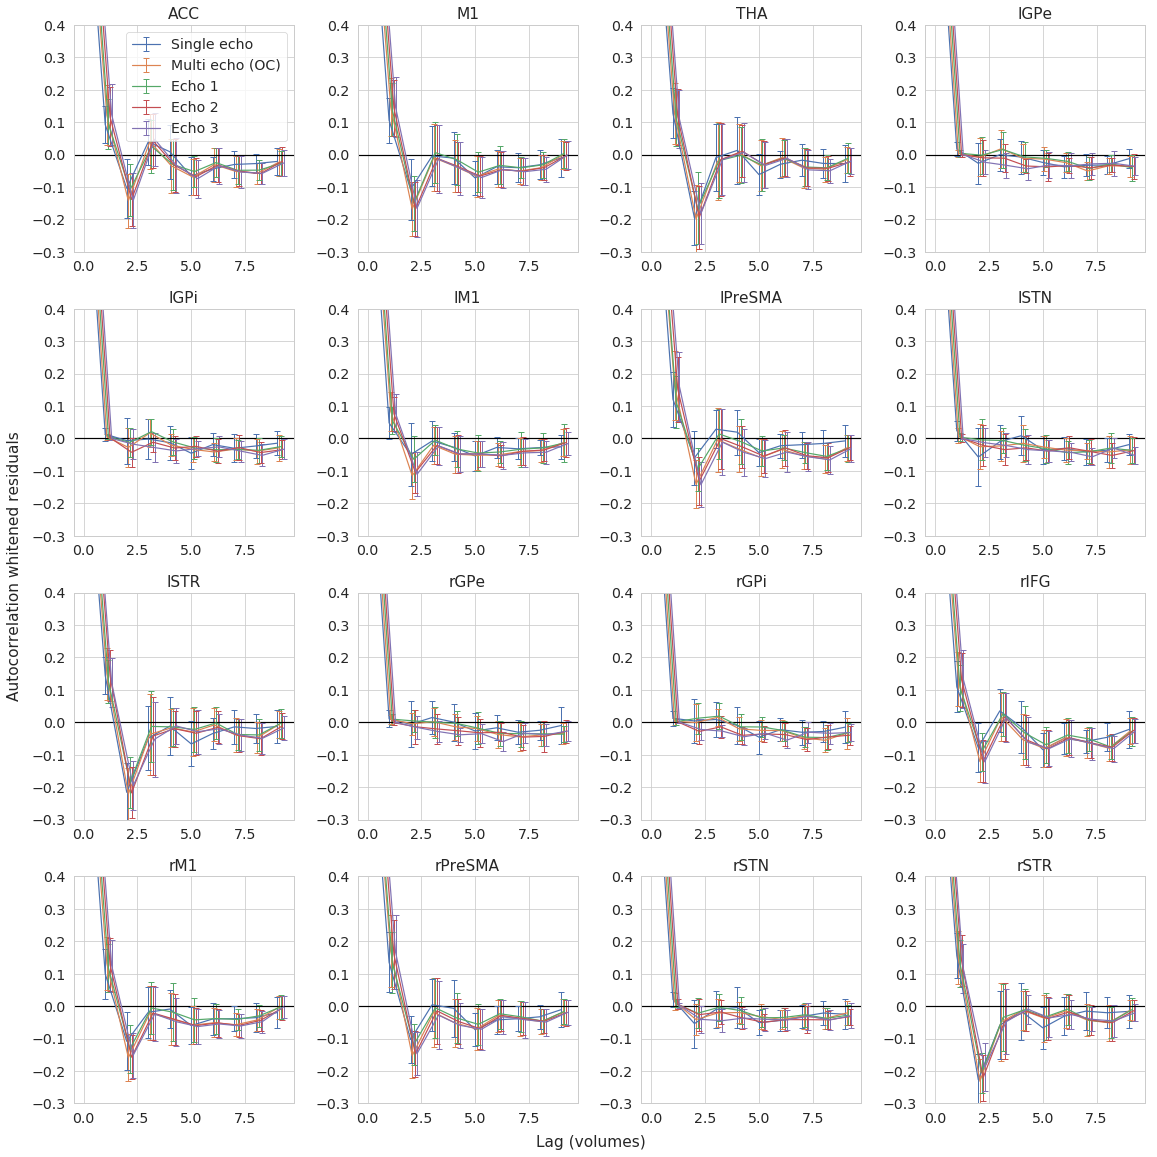

In [243]:
def residuals_acf(x, roi_idx=0, whitened_residuals=True):
    
    use_residuals = x._residuals.iloc[:,roi_idx].values
    if whitened_residuals:
        use_residuals = x.gls_models[roi_idx].cholsigmainv.dot(use_residuals)

    return pd.Series(acf(use_residuals), index=np.arange(10))

# get roi names
tmp = rfGroupsCwD['psc']['se']._get_response_fitters()[0]
roi_names = [x for x in tmp.input_signal.columns]

## plot
lags = np.arange(10)
f, axes = plt.subplots(nrows=4, ncols=4)
ses_lab_dict = {'se': 'Single echo', 'optcomb': 'Multi echo (OC)', 
                'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3'}
for i, ax in enumerate(axes.ravel()):
    ax.axhline(color='black')
    
    roi_name = roi_names[i]
    for ii, (ses, lab) in enumerate(ses_lab_dict.items()):
        resids_rho = rfGroupsCwD['psc'][ses]._get_response_fitters().apply(residuals_acf, roi_idx=i)
        mns = resids_rho.mean(axis=0)
        stds = resids_rho.std(axis=0)
        ax.errorbar(x=lags+.075*ii, y=mns, yerr=stds, capsize=3, elinewidth=1, label=lab)
    ax.set_title(roi_name)
    ax.set_ylim([-.3, .4])
    if i == 0:
        ax.legend()

f.text(0.5, 0, 'Lag (volumes)', ha='center', va='center')
f.text(0.00, 0.5, 'Autocorrelation whitened residuals', ha='center', va='center', rotation='vertical')

f.set_size_inches(16, 16)
f.tight_layout()
f.savefig('./figures/autocorrelation_whitened_residuals.pdf')

Since the remaining autocorrelation pattern does not seem to depend on the protocol / data type, this suggests (to me) that it's physiological autocorrelation. This also explains why there's minor differences in the remaining autocorrelation in lSTN (no signal / no physiological signal left in the later echos, so also no autocorrelation)

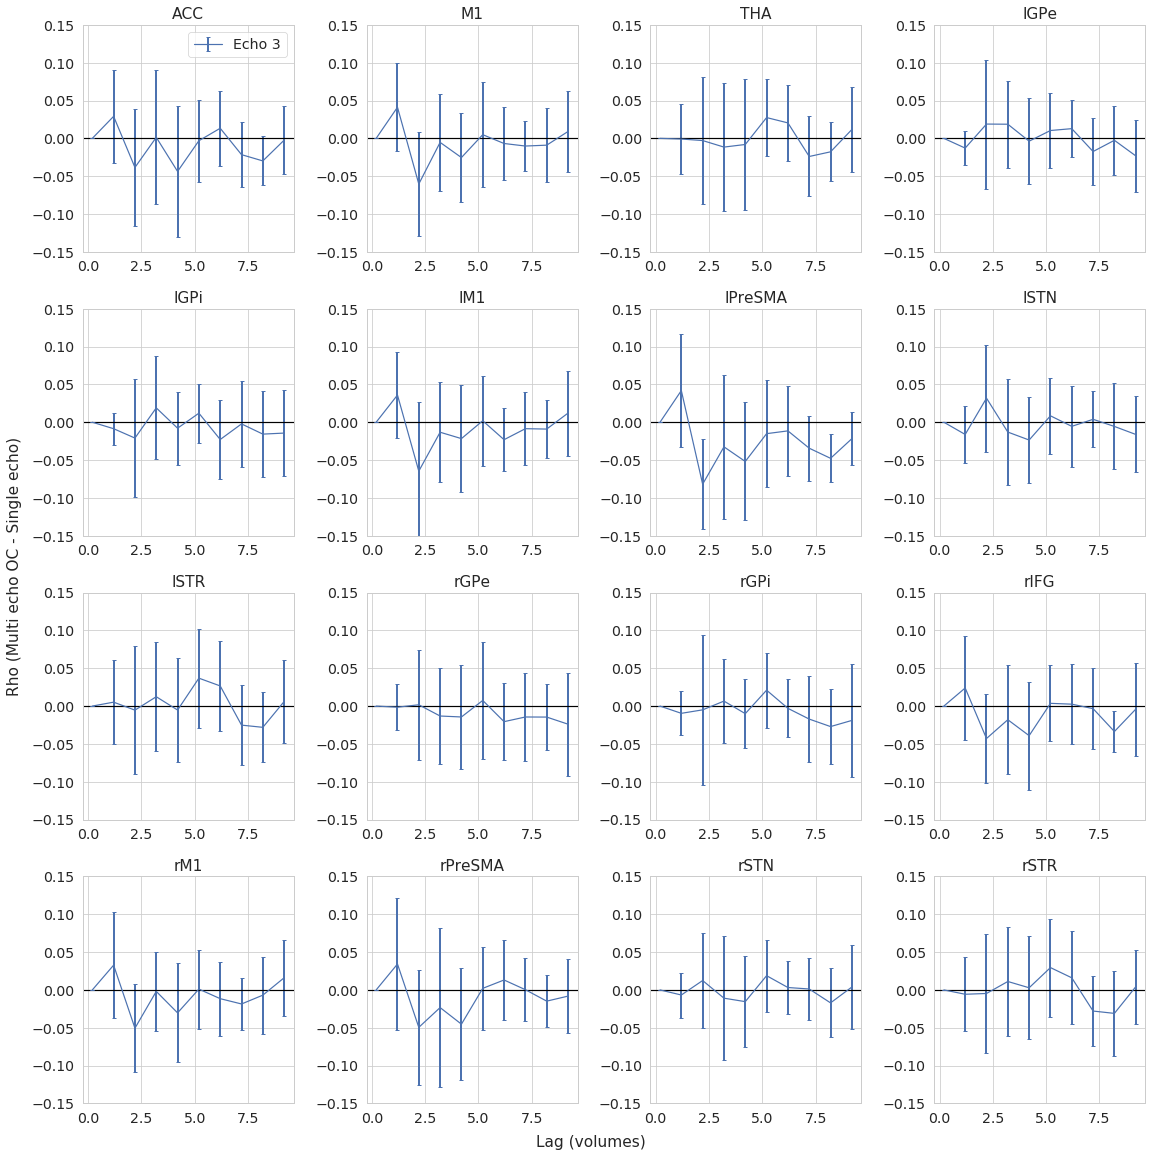

In [244]:
def residuals_acf(x, roi_idx=0, whitened_residuals=True):
    
    use_residuals = x._residuals.iloc[:,roi_idx].values
    if whitened_residuals:
        use_residuals = x.gls_models[roi_idx].cholsigmainv.dot(use_residuals)

    return pd.Series(acf(use_residuals), index=np.arange(10))

# get roi names
tmp = rfGroupsCwD['psc']['se']._get_response_fitters()[0]
roi_names = [x for x in tmp.input_signal.columns]

## plot
lags = np.arange(10)
f, axes = plt.subplots(nrows=4, ncols=4)
# ses_lab_dict = {'se': 'Single echo', 'optcomb': 'Multi echo (OC)', 
#                 'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3'}
for i, ax in enumerate(axes.ravel()):
    ax.axhline(color='black')
    
    roi_name = roi_names[i]
    resids_rho_me = rfGroupsCwD['psc']['optcomb']._get_response_fitters().apply(residuals_acf, roi_idx=i)
    resids_rho_se = rfGroupsCwD['psc']['se']._get_response_fitters().apply(residuals_acf, roi_idx=i)
    rho_diff = resids_rho_me - resids_rho_se
    mns = rho_diff.mean(axis=0)
    stds = rho_diff.std(axis=0)

    ax.errorbar(x=lags+.05*ii, y=mns, yerr=stds, capsize=2, elinewidth=2, label=lab)
    ax.set_title(roi_name)
    ax.set_ylim([-.15, .15])
    if i == 0:
        ax.legend()

f.set_size_inches(16, 16)
f.tight_layout()

f.text(0.5, 0, 'Lag (volumes)', ha='center', va='center')
f.text(0.0, 0.5, 'Rho (Multi echo OC - Single echo)', ha='center', va='center', rotation='vertical')

f.savefig('./figures/autocorrelation_whitened_residuals_delta.pdf')

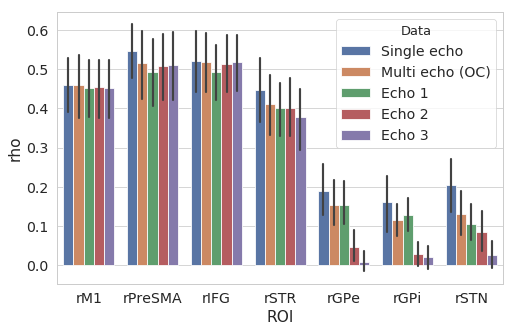

In [245]:
# what about rhos per ROI?
df = []
for ses, label in ses_lab_dict.items():
    rhos = rfGroupsCwD['psc'][ses]._get_response_fitters().apply(lambda x: pd.Series(x.rhos[:,0], index=roi_names))
    rhos = rhos.reset_index().melt(id_vars='subject', value_name='rho', var_name='ROI')
    rhos['Data'] = label
    df.append(rhos)
rhos = pd.concat(df)

sns.barplot(x='ROI', y='rho', hue='Data', data=rhos, order=['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN'])
plt.gcf().set_size_inches(8, 5)

# so yes there's some rho differences, again mainly in subcortical areas
# Speculatively, this is a consequence of the low tSNR of the later echoes in subcortical areas;
# most of the 'signal' is actually noise, which is pretty much white at the last echo.

# the residual autocorrelation appears to be related to "signal" (something physiological?)

In [280]:
roi_names

['ACC',
 'M1',
 'THA',
 'lGPe',
 'lGPi',
 'lM1',
 'lPreSMA',
 'lSTN',
 'lSTR',
 'rGPe',
 'rGPi',
 'rIFG',
 'rM1',
 'rPreSMA',
 'rSTN',
 'rSTR']

In [281]:
## variance-covariance matrix of residuals of echos
roi_idx = 4
whitened_residuals1 = rfGroupsCwD['psc']['echo_1']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))
whitened_residuals2 = rfGroupsCwD['psc']['echo_2']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))
whitened_residuals3 = rfGroupsCwD['psc']['echo_3']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))

residual_df = pd.concat([whitened_residuals1, whitened_residuals2, whitened_residuals3], axis=1)
vcv12 = residual_df.apply(lambda x: np.cov(x[0], x[1]), axis=1).mean(axis=0)
vcv23 = residual_df.apply(lambda x: np.cov(x[1], x[2]), axis=1).mean(axis=0)
vcv13 = residual_df.apply(lambda x: np.cov(x[0], x[2]), axis=1).mean(axis=0)

In [282]:
vcv12

array([[0.27829366, 0.10796552],
       [0.10796552, 1.18858242]])

In [283]:
vcv23

array([[1.18858242, 0.33188331],
       [0.33188331, 2.98872283]])

In [284]:
vcv13

array([[0.27829366, 0.12343056],
       [0.12343056, 2.98872283]])

In [285]:
# not really sure what to do with this? There's correlations, but that's to be expected I think?

#### Calculate differences in t-values between the single echo and multi echo data

In [53]:
t_vals_long.head()

,subject,Data,Event,ROI,t
0,01,Single echo,Successful stop,ACC,1.042083
1,02,Single echo,Successful stop,ACC,6.969561
2,03,Single echo,Successful stop,ACC,7.860777
3,04,Single echo,Successful stop,ACC,2.238278
4,05,Single echo,Successful stop,ACC,8.888314


In [54]:
t_vals_long.to_csv('/home/stevenm/Desktop/t_vals.csv')

In [55]:
#t_vals_long

import numpy as np 
import pylab 
import scipy.stats as stats

#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
#stats.probplot(measurements, dist="norm", plot=pylab)
#pylab.show()

In [57]:
# for ROI in t_vals_long.ROI.unique():
#     for event in t_vals_long.Event.unique():
#         f = plt.figure()
#         stats.probplot(t_vals_long.loc[(t_vals_long.ROI == ROI) & (t_vals_long.Event == event), 't'], dist='norm', plot=matplotlib.pyplot)

In [58]:
def get_protocol_differences(x, dv='t'):
    se_oc = x.loc[x['Data'] == 'Single echo', dv].values - x.loc[x['Data'] == 'Multi echo (OC)', dv].values
    
    return pd.Series({'Single echo - Multi echo': se_oc[0]})

t_differences = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences, dv='t').reset_index()

# Only test right-lateralized ROIs
t_differences = t_differences.loc[np.in1d(t_differences.ROI, plot_masks)]

# def get_protocol_differences_echos(x, dv='t'):
#     e1_e2 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 2', dv].values
#     e1_e3 = x.loc[x['Data'] == 'Echo 1', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
#     e2_e3 = x.loc[x['Data'] == 'Echo 2', dv].values - x.loc[x['Data'] == 'Echo 3', dv].values
    
#     return pd.Series({'Echo 1 - Echo 2': e1_e2[0],
#                       'Echo 1 - Echo 3': e1_e3[0],
#                       'Echo 2 - Echo 3': e2_e3[0]
#                       })

# pe_differences = pes_long.groupby(['Data', 'subject', 'ROI']).apply(get_contrast_differences, dv='pe').reset_index()
# t_differences_echo = t_vals_long.groupby(['Event', 'subject', 'ROI']).apply(get_protocol_differences_echos, dv='t').reset_index()

# Only test right-lateralized ROIs
# pe_differences = pe_differences.loc[np.in1d(pe_differences.ROI, plot_masks)]
# t_differences_echo = t_differences_echo.loc[np.in1d(t_differences_echo.ROI, plot_masks)]

In [59]:
t_differences.head()

,Event,subject,ROI,Single echo - Multi echo
9,Failed stop,01,rGPe,-0.105478
10,Failed stop,01,rGPi,-1.193195
11,Failed stop,01,rIFG,-0.093128
12,Failed stop,01,rM1,0.615531
13,Failed stop,01,rPreSMA,0.706476


#### Statistical test: Are the $t$-values significantly different between protocols?

1. For the regressors vs baseline

In [59]:
## OLS

# Overall test: Repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM
to_test = t_vals_long
#to_test['t'] = np.abs(to_test['t'])  # make t-value absolute
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Go', 'Failed stop', 'Successful stop'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.072,0.791
ROI,6.0,96.0,14.947,0.000
Event,2.0,32.0,19.596,0.000
Data:ROI,6.0,96.0,3.336,0.009
Data:Event,2.0,32.0,0.289,0.791
ROI:Event,12.0,192.0,9.747,0.000
Data:ROI:Event,12.0,192.0,0.993,0.640


In [60]:
## AR(1)
# Overall test: Repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM
to_test = t_vals_long
#to_test['t'] = np.abs(to_test['t'])  # make t-value absolute
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Go', 'Failed stop', 'Successful stop'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.000,0.994
ROI,6.0,96.0,20.787,0.000
Event,2.0,32.0,24.148,0.000
Data:ROI,6.0,96.0,2.955,0.019
Data:Event,2.0,32.0,0.164,0.991
ROI:Event,12.0,192.0,8.410,0.000
Data:ROI:Event,12.0,192.0,0.788,0.928


So no main effect of Data (=protocol), but a Data\*ROI interaction. We follow-up on that below, but first, the second AnovaRM with..

2. the contrasts

In [61]:
# Overall test: Repeated measures ANOVA
from statsmodels.stats.anova import AnovaRM
to_test = t_vals_long
#to_test['t'] = np.abs(to_test['t'])  # make t-value absolute
to_test = to_test.loc[(np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                      (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))]

anova = AnovaRM(data=to_test.loc[(np.in1d(to_test.Event, ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go'])) &
                                 (np.in1d(to_test.Data, ['Single echo', 'Multi echo (OC)'])) &
                                 (np.in1d(to_test.ROI, ['rM1', 'rIFG', 'rPreSMA', 'rSTR', 'rGPe', 'rGPi', 'rSTN']))], 
                depvar='t', subject='subject', within=['Data', 'ROI', 'Event'])
res = anova.fit()
res_table = res.summary().tables[0]
p_vals = res_table.iloc[:,-1]
res_table.iloc[:,-1] = multicomp.fdrcorrection0(p_vals)[1]
res_table.round(3)

,Num DF,Den DF,F Value,Pr > F
Data,1.0,16.0,0.624,0.618
ROI,6.0,96.0,38.895,0.000
Event,2.0,32.0,31.714,0.000
Data:ROI,6.0,96.0,1.674,0.237
Data:Event,2.0,32.0,0.628,0.630
ROI:Event,12.0,192.0,11.728,0.000
Data:ROI:Event,12.0,192.0,0.766,0.685


In [62]:
# Follow-up paired t-tests
to_test = t_differences
t_statistics = to_test.groupby(['Event', 'ROI'])['Single echo - Multi echo'].apply(lambda x: pd.Series({'t': stats.ttest_1samp(x, popmean=0)[0],
                                                                                         'p': stats.ttest_1samp(x, popmean=0)[1]}))
t_statistics = t_statistics.reset_index().pivot_table(values='Single echo - Multi echo', index=['Event', 'ROI'], columns='level_2').reset_index()

# Correct for multiple comparisons, separate for regressors against baseline, and contrasts
p_vals_t_regressor = t_statistics.loc[np.in1d(t_statistics.Event, ['Failed stop', 'Go', 'Successful stop'])]
p_vals_t_contrasts = t_statistics.loc[np.in1d(t_statistics.Event, ['Failed stop - successful stop', 'Failed stop - go', 'Successful stop - go'])]
p_vals_t_regressor['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_regressor['p'])[1]
p_vals_t_contrasts['p_corrected'] = multicomp.fdrcorrection0(p_vals_t_contrasts['p'])[1]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [63]:
print("After MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:")
display(p_vals_t_regressor.loc[p_vals_t_regressor['p_corrected'] < 0.05])

print("Without MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:")
display(p_vals_t_regressor.loc[p_vals_t_regressor['p'] < 0.05])

After MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:


level_2,Event,ROI,p,t,p_corrected


Without MC correction, the following $t$-values of regressors against baseline are significantly different between protocols:


level_2,Event,ROI,p,t,p_corrected
4,Failed stop,rPreSMA,0.039506,-2.241726,0.207409
21,Go,rGPe,0.005767,3.184098,0.121111
28,Successful stop,rGPe,0.024014,2.492919,0.168096
32,Successful stop,rPreSMA,0.023776,-2.497870,0.168096


In [64]:
print("After MC correction, the following $t$-values of contrasts are significantly different between protocols:")
display(p_vals_t_contrasts.loc[p_vals_t_contrasts['p_corrected'] < 0.05])

print("Without MC correction, the following $t$-values of contrasts are significantly different between protocols:")
display(p_vals_t_contrasts.loc[p_vals_t_contrasts['p'] < 0.05])

After MC correction, the following $t$-values of contrasts are significantly different between protocols:


level_2,Event,ROI,p,t,p_corrected


Without MC correction, the following $t$-values of contrasts are significantly different between protocols:


level_2,Event,ROI,p,t,p_corrected
11,Failed stop - go,rPreSMA,0.030084,-2.380143,0.631756


#### Create figure 5

In [65]:
# load (from whole-brain GLM analysis): zmaps, thresholds
import pickle as pkl
with open('glm_figure_axes/zmaps.pkl', 'rb') as f:
    zmaps_combined = pkl.load(f)

with open('glm_figure_axes/thresholds.pkl', 'rb') as f:
    thresholds_combined = pkl.load(f)
    
from nilearn import plotting

bg_img = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

from utils import get_roi_dict, add_contours, get_prop_limits
roi_map = get_roi_dict()

In [66]:
from functools import partial

plot_spm = partial(plotting.plot_stat_map, 
                   bg_img=bg_img, display_mode='y', cut_coords=[-13], 
                   colorbar=None, annotate=False, vmax=6)

def add_rois(disp, roi_dict):
    plot_rois = ['rIFG', 'M1',
             'lSTR', 'lGPe', 'lGPi', 'lSTN',
             'rSTR', 'rGPe', 'rGPi', 'rSTN']
    for roi_ in plot_rois:
        roi_map = roi_dict[roi_]
        add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

def fix_lims(disp, display_mode='y'):
    # determine limits (xlim/ylim) based on first column, and apply to all others
    this_key = list([x for x in disp.axes.keys()])[0]
    # Determine new xlim/ylim
    cur_xlim = disp.axes[this_key].ax.get_xlim()
    cur_ylim = disp.axes[this_key].ax.get_ylim()
    if display_mode == 'x':
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0, 1], cur_ylim)
    elif display_mode == 'z' and 'STN' in roi:
        new_xlim = get_prop_limits([.25, .75], cur_xlim)
        new_ylim = get_prop_limits([.40, .90], cur_ylim)
    elif display_mode == 'z' and 'STR' in roi:
        new_xlim = get_prop_limits([0, 1], cur_xlim)
        new_ylim = get_prop_limits([0.3, 1], cur_ylim)
    elif display_mode == 'y':
        new_xlim = get_prop_limits([.26, .74], cur_xlim)
        new_ylim = get_prop_limits([.25, .75], cur_ylim)

    # Change axes limits
    disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
    disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])

In [76]:
# f, axes = plt.subplots(3, 3)
# gs0 = gridspec.GridSpec(3, 3, figure=f)
# cm = plt.get_cmap('Pastel2')
# #norm = colors.Normalize(vmin=0, vmax=2)
# title_bgcolors = {'Failed stop - successful stop': cm(0), 
#                   'Failed stop - go': cm(3), 
#                   'Successful stop - go': cm(4)}

# location_dict = {'Failed stop': [0, 0],
#                  'Go': [1, 1],
#                  'Successful stop': [2, 2],
                 
#                  'Failed stop - go': [1, 0],
#                  'Failed stop - successful stop': [2, 0],
#                  'Successful stop - go': [2, 1]}

# for contrast, loc in location_dict.items(): 
#     ax = axes[loc[0], loc[1]]
#     sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
#                 data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
#                                      np.in1d(t_vals_long.ROI, plot_masks) & 
#                                      np.in1d(t_vals_long.Data, ['Echo 1','Echo 2','Echo 3'])], 
#                 ci=67)
#     if contrast in ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go']:
#         ax.set_title(contrast)
#     else:
#         ax.set_title(contrast)
        

# leg = axes.ravel()[-1].legend(loc=1, bbox_to_anchor=[1.8, 1])
# leg.set_title('')

# for i, ax_ in enumerate(axes.ravel()):
#     if i < (len(axes.ravel())-1):
#         ax_.legend().set_visible(False)
#     ax_.set_xlabel('')
#     ax_.set_ylabel('')
# axes[1,0].set_ylabel('$t$-values')

# for row in [0,1]:
#     for col in [0, 1, 2]:
#         axes[row, col].tick_params(axis='x',          # changes apply to the x-axis
#                                    which='both',      # both major and minor ticks are affected
#                                    bottom=False,      # ticks along the bottom edge are off
#                                    top=False,         # ticks along the top edge are off
#                                    labelbottom=False) # labels along the bottom edge are off
# for col in [0, 1, 2]:
#     axes[2, col].tick_params(axis='x', which='both', rotation=90)
# # turn off other axes to remove background grid
# axes[0, 1].axis('Off')
# axes[0, 1].set_title('Failed stop - go')
# axes[0, 2].axis('Off')
# axes[0, 2].set_title('Failed stop - successful stop')
# axes[1, 2].axis('Off')
# axes[1, 2].set_title('Successful stop - go')

# f.set_size_inches(14,10)
# f.savefig('figures/t_by_echo.pdf', bbox_inches='tight')

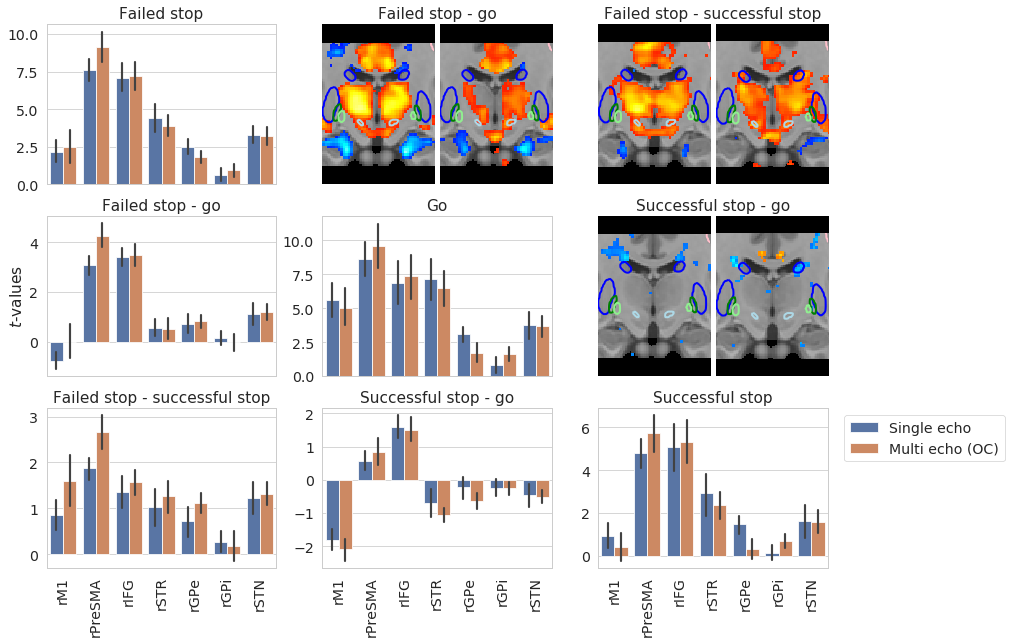

In [67]:
# Change font size
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
# fontsize = 22
# font = {'family' : 'normal',
#         'weight': 'normal',
#         'size'   : 22}
# matplotlib.rc('font', **font)
# matplotlib.rc('axes', titlesize=fontsize)

sns.set_context("paper", font_scale=1.60)


f, axes = plt.subplots(3, 3)
gs0 = gridspec.GridSpec(3, 3, figure=f)
cm = plt.get_cmap('Pastel2')
#norm = colors.Normalize(vmin=0, vmax=2)
title_bgcolors = {'Failed stop - successful stop': cm(0), 
                  'Failed stop - go': cm(3), 
                  'Successful stop - go': cm(4)}

location_dict = {'Failed stop': [0, 0],
                 'Go': [1, 1],
                 'Successful stop': [2, 2],
                 
                 'Failed stop - go': [1, 0],
                 'Failed stop - successful stop': [2, 0],
                 'Successful stop - go': [2, 1]}

for contrast, loc in location_dict.items(): 
    ax = axes[loc[0], loc[1]]
    sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
                data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
                                     np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
                ci=67)
    if contrast in ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go']:
        ax.set_title(contrast)
    else:
        ax.set_title(contrast)

leg = axes.ravel()[-1].legend(loc=1, bbox_to_anchor=[1.8, 1])
leg.set_title('')

for i, ax_ in enumerate(axes.ravel()):
    if i < (len(axes.ravel())-1):
        ax_.legend().set_visible(False)
    ax_.set_xlabel('')
    ax_.set_ylabel('')
axes[1,0].set_ylabel('$t$-values')

for row in [0,1]:
    for col in [0, 1, 2]:
        axes[row, col].tick_params(axis='x',          # changes apply to the x-axis
                                   which='both',      # both major and minor ticks are affected
                                   bottom=False,      # ticks along the bottom edge are off
                                   top=False,         # ticks along the top edge are off
                                   labelbottom=False) # labels along the bottom edge are off
for col in [0, 1, 2]:
    axes[2, col].tick_params(axis='x', which='both', rotation=90)
# turn off other axes to remove background grid
axes[0, 1].axis('Off')
axes[0, 1].set_title('Failed stop - go')
axes[0, 2].axis('Off')
axes[0, 2].set_title('Failed stop - successful stop')
axes[1, 2].axis('Off')
axes[1, 2].set_title('Successful stop - go')

# plot SPMs
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,1], wspace=0.05)
ax01_0 = plt.Subplot(f, gs01[0])
f.add_subplot(ax01_0)
disp = plot_spm(zmaps_combined[0], threshold=thresholds_combined[0], axes=ax01_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

ax01_1 = plt.Subplot(f, gs01[1])
f.add_subplot(ax01_1)
disp = plot_spm(zmaps_combined[1], threshold=thresholds_combined[1], axes=ax01_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,2], wspace=0.05)
ax02_0 = plt.Subplot(f, gs02[0])
f.add_subplot(ax02_0)
disp = plot_spm(zmaps_combined[4], threshold=thresholds_combined[4], axes=ax02_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)
ax02_1 = plt.Subplot(f, gs02[1])
f.add_subplot(ax02_1)
disp = plot_spm(zmaps_combined[5], threshold=thresholds_combined[5], axes=ax02_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)


gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1,2], wspace=0.05)
ax12_0 = plt.Subplot(f, gs12[0])
f.add_subplot(ax12_0)
disp = plot_spm(zmaps_combined[2], threshold=thresholds_combined[2], axes=ax12_0)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)
ax12_1 = plt.Subplot(f, gs12[1])
f.add_subplot(ax12_1)
disp = plot_spm(zmaps_combined[3], threshold=thresholds_combined[3], axes=ax12_1)
add_rois(disp, roi_dict=roi_map)
fix_lims(disp)

f.set_size_inches(14, 10)
#f.savefig('figures/figure5.pdf', bbox_inches='tight')

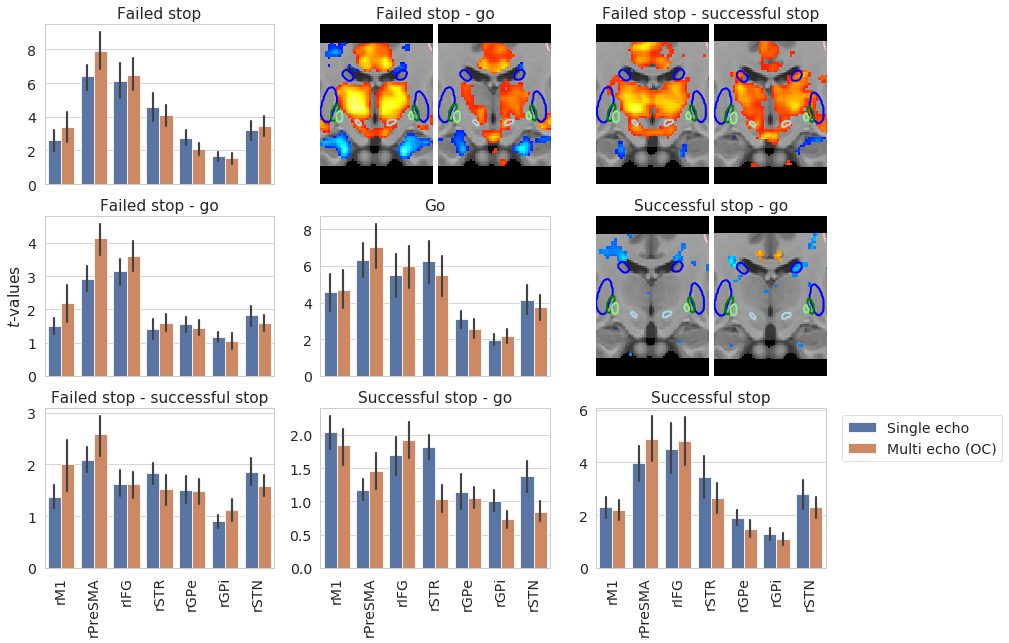

In [80]:
# # Change font size
# from matplotlib.offsetbox import AnchoredText
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib
# # fontsize = 22
# # font = {'family' : 'normal',
# #         'weight': 'normal',
# #         'size'   : 22}
# # matplotlib.rc('font', **font)
# # matplotlib.rc('axes', titlesize=fontsize)

# sns.set_context("paper", font_scale=1.60)


# f, axes = plt.subplots(3, 3)
# gs0 = gridspec.GridSpec(3, 3, figure=f)
# cm = plt.get_cmap('Pastel2')
# #norm = colors.Normalize(vmin=0, vmax=2)
# title_bgcolors = {'Failed stop - successful stop': cm(0), 
#                   'Failed stop - go': cm(3), 
#                   'Successful stop - go': cm(4)}

# location_dict = {'Failed stop': [0, 0],
#                  'Go': [1, 1],
#                  'Successful stop': [2, 2],
                 
#                  'Failed stop - go': [1, 0],
#                  'Failed stop - successful stop': [2, 0],
#                  'Successful stop - go': [2, 1]}

# for contrast, loc in location_dict.items(): 
#     ax = axes[loc[0], loc[1]]
#     sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
#                 data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
#                                      np.in1d(t_vals_long.ROI, plot_masks) & 
#                                      np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
#                 ci=67)
#     if contrast in ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go']:
#         ax.set_title(contrast)
#     else:
#         ax.set_title(contrast)

# leg = axes.ravel()[-1].legend(loc=1, bbox_to_anchor=[1.8, 1])
# leg.set_title('')

# for i, ax_ in enumerate(axes.ravel()):
#     if i < (len(axes.ravel())-1):
#         ax_.legend().set_visible(False)
#     ax_.set_xlabel('')
#     ax_.set_ylabel('')
# axes[1,0].set_ylabel('$t$-values')

# for row in [0,1]:
#     for col in [0, 1, 2]:
#         axes[row, col].tick_params(axis='x',          # changes apply to the x-axis
#                                    which='both',      # both major and minor ticks are affected
#                                    bottom=False,      # ticks along the bottom edge are off
#                                    top=False,         # ticks along the top edge are off
#                                    labelbottom=False) # labels along the bottom edge are off
# for col in [0, 1, 2]:
#     axes[2, col].tick_params(axis='x', which='both', rotation=90)
# # turn off other axes to remove background grid
# axes[0, 1].axis('Off')
# axes[0, 1].set_title('Failed stop - go')
# axes[0, 2].axis('Off')
# axes[0, 2].set_title('Failed stop - successful stop')
# axes[1, 2].axis('Off')
# axes[1, 2].set_title('Successful stop - go')

# # plot SPMs
# gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,1], wspace=0.05)
# ax01_0 = plt.Subplot(f, gs01[0])
# f.add_subplot(ax01_0)
# disp = plot_spm(zmaps_combined[0], threshold=thresholds_combined[0], axes=ax01_0)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)

# ax01_1 = plt.Subplot(f, gs01[1])
# f.add_subplot(ax01_1)
# disp = plot_spm(zmaps_combined[1], threshold=thresholds_combined[1], axes=ax01_1)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)

# gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0,2], wspace=0.05)
# ax02_0 = plt.Subplot(f, gs02[0])
# f.add_subplot(ax02_0)
# disp = plot_spm(zmaps_combined[4], threshold=thresholds_combined[4], axes=ax02_0)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)
# ax02_1 = plt.Subplot(f, gs02[1])
# f.add_subplot(ax02_1)
# disp = plot_spm(zmaps_combined[5], threshold=thresholds_combined[5], axes=ax02_1)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)


# gs12 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1,2], wspace=0.05)
# ax12_0 = plt.Subplot(f, gs12[0])
# f.add_subplot(ax12_0)
# disp = plot_spm(zmaps_combined[2], threshold=thresholds_combined[2], axes=ax12_0)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)
# ax12_1 = plt.Subplot(f, gs12[1])
# f.add_subplot(ax12_1)
# disp = plot_spm(zmaps_combined[3], threshold=thresholds_combined[3], axes=ax12_1)
# add_rois(disp, roi_dict=roi_map)
# fix_lims(disp)

# f.set_size_inches(14, 10)
# #f.savefig('figures/figure5.pdf', bbox_inches='tight')

Note an interesting aspect: in rSTN, the "Go vs baseline" (center barplot) $t$-values seem to be higher than the failed stop or successful stop $t$-values. This has to do with improved power for detecting a _go_ effect than a _failed stop_ or _successful stop_: More trials, plus a more efficient design matrix. See, for example, the actual PEs:

In [68]:
pes_long.loc[(np.in1d(pes_long['Data'], ['Single echo', 'Multi echo (OC)'])) & 
             (pes_long['ROI'] == 'rSTN') & (np.in1d(pes_long['Event'], ['Failed stop', 'Successful stop', 'Go']))].groupby(['Data', 'Event', 'ROI'])['pe'].mean()

Data             Event            ROI 
Multi echo (OC)  Failed stop      rSTN    0.424221
                 Go               rSTN    0.268570
                 Successful stop  rSTN    0.188565
Single echo      Failed stop      rSTN    0.378625
                 Go               rSTN    0.243232
                 Successful stop  rSTN    0.193997
Name: pe, dtype: float64

And the differences in efficiency in the design matrix for detecting the different effects

In [69]:
X = rfGroupsCwD['psc']['se']._get_response_fitters()[0].X
regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
successful_stop_vs_baseline = (regressor_names == 'successful_stop_intercept_canonical_hrf').astype(int)
failed_stop_vs_baseline = (regressor_names == 'failed_stop_intercept_canonical_hrf').astype(int)
go_trial_vs_baseline = (regressor_names == 'go_trial_intercept_canonical_hrf').astype(int)

for C in [successful_stop_vs_baseline, failed_stop_vs_baseline, go_trial_vs_baseline]:
    print(1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C))

# The design matrix is much better suited for detecting go trial effects than the other two. Which makes total sense,
# since there's 4x as many go trials than stop trials

38.71496416428634
41.521498191205
111.05528980423608


In [115]:
# For poster

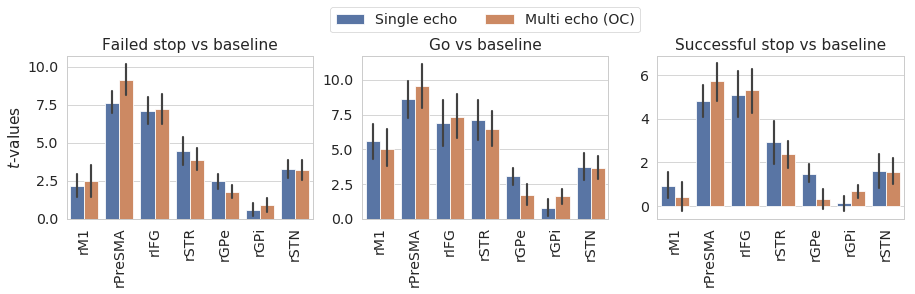

In [70]:
# Change font size
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
# fontsize = 22
# font = {'family' : 'normal',
#         'weight': 'normal',
#         'size'   : 22}
# matplotlib.rc('font', **font)
# matplotlib.rc('axes', titlesize=fontsize)

sns.set_context("paper", font_scale=1.6)


f, axes = plt.subplots(1, 3)
gs0 = gridspec.GridSpec(1, 3, figure=f)
cm = plt.get_cmap('Pastel2')
#norm = colors.Normalize(vmin=0, vmax=2)
title_bgcolors = {'Failed stop - successful stop': cm(0), 
                  'Failed stop - go': cm(3), 
                  'Successful stop - go': cm(4)}

location_dict = {'Failed stop': [0],
                 'Go': [1],
                 'Successful stop': [2]}

for contrast, loc in location_dict.items(): 
    ax = axes[loc[0]]
    sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
                data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
                                     np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Single echo', 'Multi echo (OC)'])], 
                ci=67)
    ax.set_title(contrast + ' vs baseline')

leg = axes.ravel()[1].legend(loc=8, bbox_to_anchor=[.5, 1.1], ncol=2)
leg.set_title('')

for i, ax_ in enumerate(axes.ravel()):
    if i != 1:
        ax_.legend().set_visible(False)
    ax_.set_xlabel('')
    ax_.set_ylabel('')
axes[0].set_ylabel('$t$-values')

# for col in [0, 1, 2]:
#     axes[col].tick_params(axis='x',          # changes apply to the x-axis
#                            which='both',      # both major and minor ticks are affected
#                            bottom=False,      # ticks along the bottom edge are off
#                            top=False,         # ticks along the top edge are off
#                            labelbottom=False) # labels along the bottom edge are off
for col in [0, 1, 2]:
    axes[col].tick_params(axis='x', which='both', rotation=90)

f.set_size_inches(15, 3)
#f.savefig('figures/poster_tvals.pdf', bbox_inches='tight')

# Is there a correlation between $\Delta{t} / {TE}$ and $T_2^{*}$?

#### Estimate $T_2^{*}$

In [71]:
# Get timeseries per echo
ses_ts_raw = [get_session_timeseries('echo_1', standardize=False, drop_label=False), 
              get_session_timeseries('echo_2', standardize=False, drop_label=False), 
              get_session_timeseries('echo_3', standardize=False, drop_label=False)]
ses_ts_raw = pd.concat(ses_ts_raw, axis=0)
ses_ts_raw = ses_ts_raw.reset_index().melt(id_vars=['subject', 'session', 'run', 'time'], 
                                           var_name='roi', value_name='signal')

In [72]:
import numpy as np

def fit_monoexp_decay(x, tes=[9.66, 24.87, 40.08]):
#     print(x)
    # dep var y, log-space
    log_signal = np.log(x['signal'].values).reshape(3,1)
    
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, -np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, log_signal)
    
    # back to normal space
    beta = fit[0]
    s0 = np.exp(beta[0])
    t2star = 1/beta[1]
    return pd.Series({'s0': s0, 't2s': t2star})

def mean_across_timeseries(x):
    return pd.Series({'s0': np.mean(x['s0']),
                      't2s': np.mean(x['t2s'])})

# get t2* estimate per volume
t2s = ses_ts_raw.groupby(['subject', 'run', 'roi', 'time']).apply(lambda x: fit_monoexp_decay(x))

# ...mean across timeseries...
t2s_roiwise = t2s.reset_index().drop(columns='time').groupby(['subject', 'run', 'roi']).apply(mean_across_timeseries)

# ...mean across runs
t2s_roiwise = t2s_roiwise.reset_index().groupby(['subject', 'roi']).apply(mean_across_timeseries)

# extract numeric
t2s_roiwise = t2s_roiwise.reset_index()
t2s_roiwise['s0'] = t2s_roiwise['s0'].apply(lambda x: x[0])
t2s_roiwise['t2s'] = t2s_roiwise['t2s'].apply(lambda x: x[0])

# what are the t2*-values?
t2s_roiwise.groupby('roi')['s0', 't2s'].mean()

# s0 is remarkably high for STN? Something with the application of the mask/extracting timeseries after all? 
# Although T2* is fine...

,s0,t2s
roi,,
ACC,3554.234960,33.782000
M1,4004.397884,31.617831
THA,2348.129961,27.072756
lGPe,2171.351682,12.117491
lGPi,3025.497683,17.654340
lM1,1026.514082,43.020484
lPreSMA,1960.527685,34.405198
lSTN,8772.001767,15.397410
lSTR,2527.381612,22.497721


In [94]:
## t2s_roiwise contains T2*-estimates per ROI
## Next, we fit linear functions of $t$-value ~ TE

In [73]:
def fit_linear(x, tes=[9.66, 24.87, 40.08]):
    """ Fits a linear model, estimating t ~ TE. We're interested the slope here: dt/te"""
    # design matrix X
    intercept = np.ones((3,1))
    X = np.hstack([intercept, np.array(tes).reshape((3,1))])
    
    # fit OLS
    fit = np.linalg.lstsq(X, x['t'])[0]
    return pd.Series({'intercept': fit[0], 'dt_te': fit[1]})
    
lin_model = t_vals_long.loc[np.in1d(t_vals_long.Data, 
                                    ['Echo 1', 'Echo 2', 'Echo 3'])].groupby(['subject', 'Event', 'ROI']).apply(lambda x: fit_linear(x))

# For statistics, only test the "Failed stop vs baseline" contrast, and only include the masks of interest
lin_model = lin_model.reset_index().loc[np.in1d(lin_model.reset_index()['Event'], ['Failed stop', 'Successful stop', 'Go']) & 
                                        (np.in1d(lin_model.reset_index()['ROI'], plot_masks))]

# mean dt/TE estimates across events (per roi&sub)
lin_model = lin_model.groupby(['subject', 'ROI'])[['intercept', 'dt_te']].mean().reset_index()

# Merge linear model parameter estimates with T2* estimates
t2s_dt_te_df = pd.merge(lin_model, t2s_roiwise.rename(columns={'roi': 'ROI'}), 
                        on=['subject', 'ROI'])


In [74]:
def fit_linear_2(x):
    """ Fits a linear model, estimating dt/te ~ T2s"""
    y = x['dt_te'].values[:,np.newaxis]
    intercept = np.ones_like(y)
    X = np.hstack([intercept, x['t2s'].values[:,np.newaxis]])
    
    fit = np.linalg.lstsq(X, y)[0]
    return pd.Series({'intercept_0': fit[0], 'dt_te_t2s': fit[1]})

t2s_slope_df_level2 = t2s_dt_te_df.reset_index().groupby(['subject']).apply(fit_linear_2)
t2s_slope_df_level2['intercept_0'] = t2s_slope_df_level2['intercept_0'].apply(lambda x: x[0])
t2s_slope_df_level2['dt_te_t2s'] = t2s_slope_df_level2['dt_te_t2s'].apply(lambda x: x[0])
t2s_slope_df_level2.head()

,intercept_0,dt_te_t2s
subject,,
01,-0.034922,0.000941
02,-0.150554,0.005770
03,-0.211402,0.009016
04,-0.031824,0.000853
05,-0.146457,0.007036


In [97]:
# ### Make plot of the correlation slope ~ T2*
# from matplotlib import colors
# f, ax = plt.subplots(1, 1)
# xs = np.arange(0, 50, 1)
# norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# # points per ROI, so we can color
# for i, ROI in enumerate(plot_masks):
#     t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
#     ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
#                color=plt.get_cmap('Dark2')(norm(i)), 
#                label=ROI, s=25)

# # add individual regression lines
# for sub in range(t2s_slope_df_level2.shape[0]):
#     int_, beta = t2s_slope_df_level2.iloc[sub]
#     ax.plot(xs, int_+beta*xs, alpha=0.25, color='darkblue')

# # mean reg line
# int_overall, slope_overall = t2s_slope_df_level2.mean()
# ax.plot(xs, int_overall+slope_overall*xs, color='black', linewidth=2.5)
# ax.axhline(0, color='black', linestyle='--', linewidth=1)

# # labels, legend
# ax.set_xlabel('T2* (ms)')
# ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
# ax.set_ylim([-0.2, 0.15])
# ax.set_xlim([10, 45])
# ax.legend(loc=5, bbox_to_anchor=[1.4, .65], handletextpad=0.2)

# # test for slope effect
# print(stats.ttest_1samp(t2s_slope_df_level2['dt_te_t2s'], popmean=0))
# f.savefig('figures/figure6_v2.pdf', bbox_inches='tight')

In [75]:
t_tests = t2s_dt_te_df.groupby('ROI')['dt_te'].apply(lambda x: pd.Series({'t': stats.ttest_1samp(x, 0)[0], 
                                                                          'p': stats.ttest_1samp(x, 0)[1]}))
t_tests = t_tests.reset_index().pivot_table(values='dt_te', index='ROI', columns='level_1').reset_index()

t_tests['p_corrected'] = multicomp.fdrcorrection0(t_tests['p'])[1]
t_tests

level_1,ROI,p,t,p_corrected
0,rGPe,0.006791,-3.106182,0.023770
1,rGPi,0.003168,-3.468475,0.022173
2,rIFG,0.021341,2.551445,0.037346
3,rM1,0.182454,1.393740,0.255436
4,rPreSMA,0.440549,0.790936,0.513974
5,rSTN,0.015200,-2.718037,0.035466
6,rSTR,0.570090,-0.579852,0.570090


rIFG
0.019945982344943186
0.007817524380392307
0.04026350672533549
rGPe
-0.05249169188282138
0.016899104381961697
-0.08189079626478307
rGPi
-0.034316714805970455
0.009893891166369089
-0.05671060597233954
rSTN
-0.028132976371038645
0.010350476298180276
-0.050983452669218915


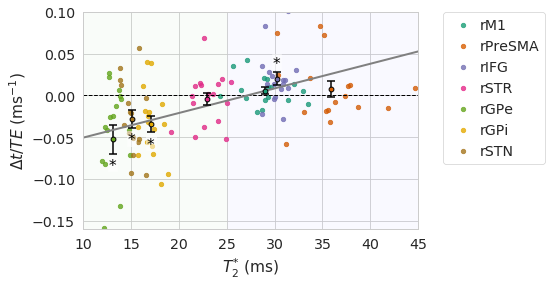

In [76]:
### Make plot of the correlation slope ~ T2*
from matplotlib import colors
f, ax = plt.subplots(1, 1)
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# gradient = np.linspace(0, 1, 100).reshape(1, -1)
# plt.imshow(gradient , extent=[-0.25, 3.25, -1, n], aspect='auto', cmap='RdYlGn_r')
# sns.stripplot(x=values, y=names, color='b', size=12, edgecolor='b')
# plt.hlines(np.arange(0, n), -0.25, 3.25, linestyles='--', linewidth=1)

# background shade
#     plt.axhspan(i, i+.2, facecolor='0.2', alpha=0.5)
plt.axvspan(0, 25, facecolor='green', alpha=0.025)
plt.axvspan(25, 50, facecolor='blue', alpha=0.025)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
# mean reg line
int_overall, slope_overall = t2s_slope_df_level2.mean()
ax.plot(xs, int_overall+slope_overall*xs, color='grey', linewidth=2)

# points per ROI, so we can color
for i, ROI in enumerate(plot_masks):
    t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
    ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
               color=plt.get_cmap('Dark2')(norm(i)), 
               label=ROI, s=20, alpha=.8)
    mean_t2s = t2s_this_roi['t2s'].mean()
    mean_dtte = t2s_this_roi['dt_te'].mean()
    sem = t2s_this_roi['dt_te'].std()/np.sqrt(17)
    ax.errorbar(mean_t2s, mean_dtte, yerr=sem, linewidth=1.5, color='black', capsize=4, capthick=1.5, fmt='o',
                markerfacecolor=plt.get_cmap('Dark2')(norm(i)))
    if t_tests.loc[t_tests.ROI==ROI, 'p_corrected'].values[0] < 0.05:
        if t_tests.loc[t_tests.ROI==ROI, 't'].values[0] > 0:
            y_loc = mean_dtte + sem + 0.0125
        else:
            y_loc = mean_dtte - sem - 0.0125
        print(ROI)
        print(mean_dtte)
        print(sem)
        print(y_loc)

        # add significance star
        t = plt.text(x=mean_t2s, y=y_loc, s='$*$', ha='center', va='center', color='black', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
# labels, legend
ax.set_xlabel('$T_2^{*}$ (ms)')
ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
ax.set_ylim([-0.16, 0.10])
ax.set_xlim([10, 45])
ax.legend(loc=5, bbox_to_anchor=[1.4, .65], handletextpad=0.2)

ax_tmp = ax
# f.savefig('figures/figure6_opt3.pdf', bbox_inches='tight')

rIFG
0.013776003803332753
0.005210156913006255
0.03148616071633901
rGPe
-0.03230267356807842
0.011946381429916785
-0.05674905499799521
rSTN
-0.02645157558075864
0.00758069344551855
-0.04653226902627719


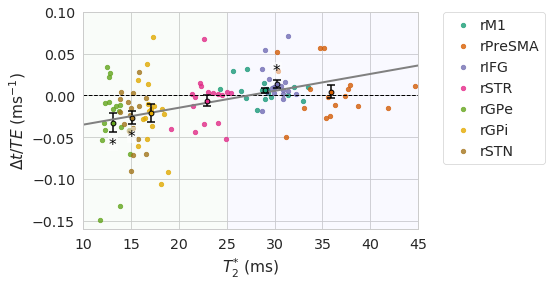

In [99]:
### Make plot of the correlation slope ~ T2*
from matplotlib import colors
f, ax = plt.subplots(1, 1)
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# gradient = np.linspace(0, 1, 100).reshape(1, -1)
# plt.imshow(gradient , extent=[-0.25, 3.25, -1, n], aspect='auto', cmap='RdYlGn_r')
# sns.stripplot(x=values, y=names, color='b', size=12, edgecolor='b')
# plt.hlines(np.arange(0, n), -0.25, 3.25, linestyles='--', linewidth=1)

# background shade
#     plt.axhspan(i, i+.2, facecolor='0.2', alpha=0.5)
plt.axvspan(0, 25, facecolor='green', alpha=0.025)
plt.axvspan(25, 50, facecolor='blue', alpha=0.025)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
# mean reg line
int_overall, slope_overall = t2s_slope_df_level2.mean()
ax.plot(xs, int_overall+slope_overall*xs, color='grey', linewidth=2)

# points per ROI, so we can color
for i, ROI in enumerate(plot_masks):
    t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
    ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
               color=plt.get_cmap('Dark2')(norm(i)), 
               label=ROI, s=20, alpha=.8)
    mean_t2s = t2s_this_roi['t2s'].mean()
    mean_dtte = t2s_this_roi['dt_te'].mean()
    sem = t2s_this_roi['dt_te'].std()/np.sqrt(17)
    ax.errorbar(mean_t2s, mean_dtte, yerr=sem, linewidth=1.5, color='black', capsize=4, capthick=1.5, fmt='o',
                markerfacecolor=plt.get_cmap('Dark2')(norm(i)))
    if t_tests.loc[t_tests.ROI==ROI, 'p_corrected'].values[0] < 0.05:
        if t_tests.loc[t_tests.ROI==ROI, 't'].values[0] > 0:
            y_loc = mean_dtte + sem + 0.0125
        else:
            y_loc = mean_dtte - sem - 0.0125
        print(ROI)
        print(mean_dtte)
        print(sem)
        print(y_loc)

        # add significance star
        t = plt.text(x=mean_t2s, y=y_loc, s='$*$', ha='center', va='center', color='black', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
# labels, legend
ax.set_xlabel('$T_2^{*}$ (ms)')
ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
ax.set_ylim([-0.16, 0.10])
ax.set_xlim([10, 45])
ax.legend(loc=5, bbox_to_anchor=[1.4, .65], handletextpad=0.2)

ax_tmp = ax
# f.savefig('figures/figure6_opt3.pdf', bbox_inches='tight')

rGPe
-0.05249169188282138
0.016899104381961697
-0.08189079626478307
rSTN
-0.028132976371038645
0.010350476298180276
-0.050983452669218915
rGPi
-0.034316714805970455
0.009893891166369089
-0.05671060597233954
rIFG
0.019945982344943186
0.007817524380392307
0.04026350672533549


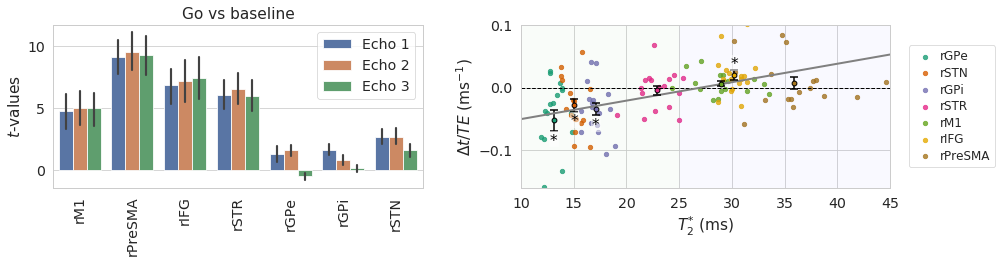

In [77]:
#gs_kws = {'width_ratios': [1, 1, 1, .2, 1.6]}

gs_kws = {'width_ratios': [1, .00, 1]}
f, axes = plt.subplots(1, 3, gridspec_kw=gs_kws)
axes[-2].axis('Off')

location_dict = {#'Failed stop': [0],
                 'Go': [0],
}#'Successful stop': [2]}

for contrast, loc in location_dict.items(): 
    ax = axes[loc[0]]
    sns.barplot(x='ROI', y='t', hue='Data', ax=ax, order=plot_masks, 
                data=t_vals_long.loc[np.in1d(t_vals_long.Event, contrast) &
                                     np.in1d(t_vals_long.ROI, plot_masks) & 
                                     np.in1d(t_vals_long.Data, ['Echo 1','Echo 2','Echo 3'])], 
                ci=67)
    #if contrast in ['Failed stop - go', 'Failed stop - successful stop', 'Successful stop - go']:
    ax.set_title('Go vs baseline')

leg = axes.ravel()[-2].legend(loc=1, bbox_to_anchor=[1.8, 1])
leg.set_title('')
leg = axes.ravel()[0].legend()#loc=1, bbox_to_anchor=[1.8, 1])
leg.set_title('')

for i, ax_ in enumerate(axes.ravel()[:-1]):
    if i == 0:
        ax_.legend()#loc=8, bbox_to_anchor=[.5, 1.1], handletextpad=0.2, ncol=3, mode=None,
#          labelspacing=.3, columnspacing=0)
        ax_.set_xlabel('')
        ax_.set_ylabel('$t$-values')
    if i != 0:
        ax_.set_xlabel('')
        ax_.legend().set_visible(False)
    if i > 0:
        ax_.set_ylabel('')
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=90)

ax = axes[-1]
xs = np.arange(0, 50, 1)
norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# background shade
#     plt.axhspan(i, i+.2, facecolor='0.2', alpha=0.5)
plt.axvspan(0, 25, facecolor='green', alpha=0.025)
plt.axvspan(25, 50, facecolor='blue', alpha=0.025)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
# mean reg line
int_overall, slope_overall = t2s_slope_df_level2.mean()
ax.plot(xs, int_overall+slope_overall*xs, color='grey', linewidth=2)

# points per ROI, so we can color
mask_ordered = ['rGPe', 'rSTN', 'rGPi', 'rSTR', 'rM1', 'rIFG', 'rPreSMA']
for i, ROI in enumerate(mask_ordered):
    t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
    ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
               color=plt.get_cmap('Dark2')(norm(i)), 
               label=ROI, s=20, alpha=.8)
    mean_t2s = t2s_this_roi['t2s'].mean()
    mean_dtte = t2s_this_roi['dt_te'].mean()
    sem = t2s_this_roi['dt_te'].std()/np.sqrt(17)
    ax.errorbar(mean_t2s, mean_dtte, yerr=sem, linewidth=1.5, color='black', capsize=4, capthick=1.5, fmt='o',
                markerfacecolor=plt.get_cmap('Dark2')(norm(i)))
    if t_tests.loc[t_tests.ROI==ROI, 'p_corrected'].values[0] < 0.05:
        if t_tests.loc[t_tests.ROI==ROI, 't'].values[0] > 0:
            y_loc = mean_dtte + sem + 0.0125
        else:
            y_loc = mean_dtte - sem - 0.0125
        print(ROI)
        print(mean_dtte)
        print(sem)
        print(y_loc)

        # add significance star
        t = plt.text(x=mean_t2s, y=y_loc, s='$*$', ha='center', va='center', color='black', weight='bold')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
# labels, legend
ax.set_xlabel('$T_2^{*}$ (ms)')
ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
ax.set_ylim([-0.16, 0.10])
ax.set_xlim([10, 45])

ax.legend(loc=5, bbox_to_anchor=[1.3, .5], handletextpad=0.2, ncol=1, mode=None,
          labelspacing=.3, columnspacing=0, prop={'size': 12})

#f.tight_layout()
f.set_size_inches(15, 3)

#f.savefig('./figures/figure6_poster.pdf', bbox_inches='tight')

In [ ]:
# ### Make plot of the correlation slope ~ T2*
# from matplotlib import colors
# f, ax = plt.subplots(1, 1)
# xs = np.arange(0, 50, 1)
# norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.ROI.unique().shape[0])

# # gradient = np.linspace(0, 1, 100).reshape(1, -1)
# # plt.imshow(gradient , extent=[-0.25, 3.25, -1, n], aspect='auto', cmap='RdYlGn_r')
# # sns.stripplot(x=values, y=names, color='b', size=12, edgecolor='b')
# # plt.hlines(np.arange(0, n), -0.25, 3.25, linestyles='--', linewidth=1)

# # background shade
# #     plt.axhspan(i, i+.2, facecolor='0.2', alpha=0.5)
# plt.axvspan(0, 25, facecolor='green', alpha=
0.025)
# plt.axvspan(25, 50, facecolor='blue', alpha=0.025)
# ax.axhline(0, color='black', linestyle='--', linewidth=1)

# # points per ROI, so we can color
# for i, ROI in enumerate(plot_masks):
#     t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI]
#     ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
#                color=plt.get_cmap('Dark2')(norm(i)), 
#                label=ROI, s=20, alpha=.8)
#     mean_t2s = t2s_this_roi['t2s'].mean()
#     mean_dtte = t2s_this_roi['dt_te'].mean()
#     sem = t2s_this_roi['dt_te'].std()/np.sqrt(17)
#     ax.errorbar(mean_t2s, mean_dtte, yerr=sem, linewidth=1.5, color='black', capsize=4, capthick=1.5
#                )
#     if t_tests.loc[t_tests.ROI==ROI, 'p_corrected'].values[0] < 0.05:
#         if t_tests.loc[t_tests.ROI==ROI, 't'].values[0] > 0:
#             y_loc = mean_dtte + sem + 0.0125
#         else:
#             y_loc = mean_dtte - sem - 0.0125
#         print(ROI)
#         print(mean_dtte)
#         print(sem)
#         print(y_loc)

#         # add significance star
#         t = plt.text(x=mean_t2s, y=y_loc, s='$*$', ha='center', va='center', color='black', weight='bold')
#         t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white', pad=0))
# # labels, legend
# ax.set_xlabel('$T_2^{*}$ (ms)')
# ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
# ax.set_ylim([-0.16, 0.10])
# ax.set_xlim([10, 45])
# ax.legend(loc=5, bbox_to_anchor=[1.4, .65], handletextpad=0.2)


# f.savefig('figures/figure6_opt2.pdf', bbox_inches='tight')

In [ ]:
# # Make plot of the correlation slope ~ T2*
# from matplotlib import colors
# f, ax = plt.subplots(1, 1)
# ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
# xs = np.arange(0, 50, 1)
# cm_name = 'tab20'
# norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.subject.unique().shape[0])

# # points per subject, so we can color
# for i, sub in enumerate(t2s_dt_te_df.subject.unique()):
#     t2s_this_roi = t2s_dt_te_df.loc[t2s_dt_te_df.subject==sub]
#     ax.scatter(t2s_this_roi['t2s'], t2s_this_roi['dt_te'], 
#                color=plt.get_cmap(cm_name)(norm(i)), 
#                label=sub, s=20)

# # add individual regression lines
# for sub in range(t2s_slope_df_level2.shape[0]):
#     int_, beta = t2s_slope_df_level2.iloc[sub]
#     ax.plot(xs, int_+beta*xs, alpha=0.3, color=plt.get_cmap(cm_name)(norm(sub)), linewidth=1.5)

# # mean reg line
# int_overall, slope_overall = t2s_slope_df_level2.mean()
# ax.plot(xs, int_overall+slope_overall*xs, color='black', linewidth=1.5)

# # labels, legend
# ax.set_xlabel('T2* (ms)')
# ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
# ax.set_ylim([-0.2, 0.2])
# ax.set_xlim([10, 45])
# # ax.legend(loc=5, bbox_to_anchor=[1.5, .5])

# prev_max = 0
# for ROI in t2s_dt_te_df.ROI.unique():
#     y_loc = 0.15
#     t2s_min_max = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI, 't2s'].min(), t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI, 't2s'].max()
#     if t2s_min_max[0] <= prev_max:
#         y_loc += .02
#     if ROI == 'rPreSMA':
#         y_loc = 0.13
#     ax.plot([t2s_min_max[0], t2s_min_max[1]], [y_loc, y_loc], 'k-')
#     xloc_txt = t2s_min_max[0] + (t2s_min_max[1] - t2s_min_max[0])/2
#     ax.text(xloc_txt+1, y_loc+.01, ROI, rotation=90, ha='right', va='bottom')
#     prev_max = t2s_min_max[1]

# # # test for slope effect
# # stats.ttest_1samp(t2s_slope_df_level2['dt_te_t2s'], popmean=0)
# # f.savefig('figures/figure6b.pdf', bbox_ inches='tight')

In [ ]:
# # Make plot of the correlation slope ~ T2*
# from matplotlib import colors
# f, ax = plt.subplots(1, 1)
# ax.axhline(0, color='black', linestyle='--', linewidth=1.5)
# xs = np.arange(0, 50, 1)
# cm_name = 'tab20'
# norm = colors.Normalize(vmin=0, vmax=t2s_dt_te_df.subject.unique().shape[0])

# prev_max = 0
# for ROI in t2s_dt_te_df.ROI.unique():
#     mean_t2s = t2s_dt_te_df.loc[t2s_dt_te_df.ROI==ROI, 't2s'].mean()
#     ax.axvline(x=mean_t2s, ymax=0.9, linestyle='--', alpha=0.5)
#     ax.text(mean_t2s, 0.17, ROI, rotation=90, ha='center', va='bottom')

# # no dot colors
# ax.scatter(t2s_dt_te_df['t2s'], t2s_dt_te_df['dt_te'], 
#            color='grey', s=20)

# # add individual regression lines, colored by sub
# for sub in range(t2s_slope_df_level2.shape[0]):
#     int_, beta = t2s_slope_df_level2.iloc[sub]
#     ax.plot(xs, int_+beta*xs, alpha=0.4, color=plt.get_cmap(cm_name)(norm(sub)), linewidth=1.5)

# # mean reg line
# int_overall, slope_overall = t2s_slope_df_level2.mean()
# ax.plot(xs, int_overall+slope_overall*xs, color='black', linewidth=1.5)

# # labels, legend
# ax.set_xlabel('T2* (ms)')
# ax.set_ylabel('$\Delta{t} / {TE}$ (ms$^{-1}$)')
# ax.set_ylim([-0.2, 0.2])
# ax.set_xlim([10, 45])
# # ax.legend(loc=5, bbox_to_anchor=[1.5, .5])


# # # test for slope effect
# # stats.ttest_1samp(t2s_slope_df_level2['dt_te_t2s'], popmean=0)
# # f.savefig('figures/figure6b.pdf', bbox_ inches='tight')

## Finally, what would the conclusions be from each ROI-wise GLM?

In [261]:
# Get MC-corrected p-values for each of the contrasts of interest, for both the OC and SE data
pe_differences_long = pes_long.loc[np.in1d(pes_long['Event'], ['Failed stop - successful stop', 'Failed stop - go', 'Successful stop - go']) &
                                   np.in1d(pes_long['ROI'], plot_masks)]
pe_differences_long['Contrast'] = pe_differences_long['Event']
pe_differences_long['Value'] = pe_differences_long['pe']
p_vals_pe = pe_differences_long.groupby(['Data', 'ROI', 'Contrast'])['Value'].apply(lambda x: pd.Series({'t': stats.ttest_1samp(x, popmean=0)[0],
                                                                                             'p': stats.ttest_1samp(x, popmean=0)[1]}))
p_vals_pe = p_vals_pe.reset_index().pivot_table(values='Value', index=['Data', 'ROI', 'Contrast'], columns='level_3').reset_index()

# separate FDR correction for the OC and SE data
p_vals_oc = p_vals_pe.loc[p_vals_pe['Data'] == 'Multi echo (OC)'].reset_index()
p_vals_se = p_vals_pe.loc[p_vals_pe['Data'] == 'Single echo'].reset_index()

# multiple comparisons correction
p_vals_oc['p_corrected'] = multicomp.fdrcorrection0(p_vals_oc['p'])[1]
p_vals_se['p_corrected'] = multicomp.fdrcorrection0(p_vals_se['p'])[1]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [266]:
print("All significant contrasts of the OC data (after MC correction):")
display(p_vals_oc.loc[p_vals_oc['p_corrected'] < 0.05])

print("All significant contrasts of the single echo data (after MC correction):")
display(p_vals_se.loc[p_vals_se['p_corrected'] < 0.05])

All significant contrasts of the OC data (after MC correction):


level_3,index,Data,ROI,Contrast,p,t,p_corrected
0,63,Multi echo (OC),rGPe,Failed stop - go,2.531997e-02,2.466537,0.037980
1,64,Multi echo (OC),rGPe,Failed stop - successful stop,6.601918e-03,3.119682,0.012604
2,65,Multi echo (OC),rGPe,Successful stop - go,1.927191e-02,-2.601757,0.033726
6,69,Multi echo (OC),rIFG,Failed stop - go,1.618708e-05,6.071481,0.000168
7,70,Multi echo (OC),rIFG,Failed stop - successful stop,2.557821e-04,4.670663,0.001074
8,71,Multi echo (OC),rIFG,Successful stop - go,1.117703e-03,3.962082,0.003353
11,74,Multi echo (OC),rM1,Successful stop - go,1.103612e-04,-5.084704,0.000579
12,75,Multi echo (OC),rPreSMA,Failed stop - go,9.549687e-07,7.669167,0.000020
13,76,Multi echo (OC),rPreSMA,Failed stop - successful stop,2.397183e-05,5.864195,0.000168
14,77,Multi echo (OC),rPreSMA,Successful stop - go,2.405579e-02,2.492049,0.037980


All significant contrasts of the single echo data (after MC correction):


level_3,index,Data,ROI,Contrast,p,t,p_corrected
6,90,Single echo,rIFG,Failed stop - go,9.382672e-07,7.679773,0.000010
7,91,Single echo,rIFG,Failed stop - successful stop,8.953779e-03,2.973894,0.031338
8,92,Single echo,rIFG,Successful stop - go,3.003378e-03,3.493679,0.012614
9,93,Single echo,rM1,Failed stop - go,1.949083e-02,-2.596195,0.045479
11,95,Single echo,rM1,Successful stop - go,6.569866e-04,-4.215409,0.003449
12,96,Single echo,rPreSMA,Failed stop - go,9.551450e-07,7.669056,0.000010
13,97,Single echo,rPreSMA,Failed stop - successful stop,1.644642e-05,6.063031,0.000115
15,99,Single echo,rSTN,Failed stop - go,1.531284e-02,2.714418,0.040196
16,100,Single echo,rSTN,Failed stop - successful stop,1.433737e-02,2.746482,0.040196


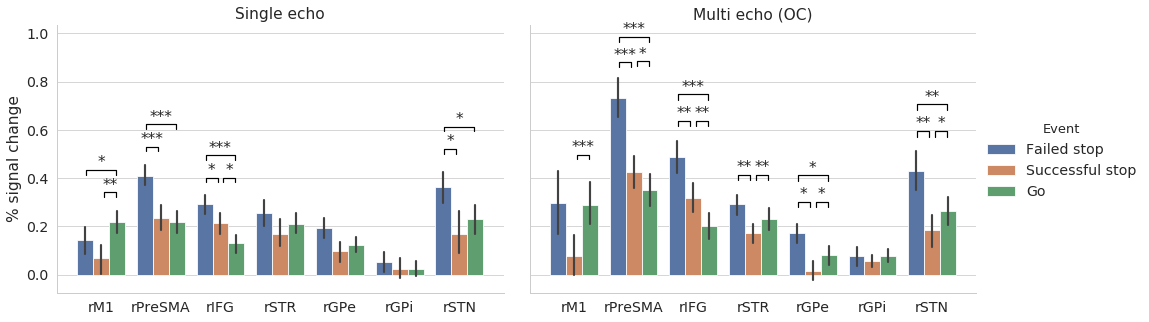

In [265]:
# Parameter estimates
# index ROIs, data types
data_to_plot = pes_long.loc[np.in1d(pes_long.ROI, plot_masks) & np.in1d(pes_long.Data, ['Single echo', 'Multi echo (OC)'])]

g = sns.catplot(x='ROI', y='pe', hue='Event', col='Data', 
                order=plot_masks, hue_order=['Failed stop', 'Successful stop', 'Go'],
                data=data_to_plot, 
                kind='bar', ci=67, aspect=1.4)
g.set_axis_labels("", "% signal change").set_titles("{col_name}")

# Get means & standard errors, useful for creating those brackets with statistics
mns = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.mean()
ses = data_to_plot.groupby(['Data', 'ROI', 'Event']).pe.apply(lambda x: np.std(x)/np.sqrt(len(x)))

# loop over ROIs
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_se.loc[(p_vals_se['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Single echo', ROI)].max()] * 3, 
                                  yerr=[ses[('Single echo', ROI)].values.max()] * 3,
                                  ax=g.axes[0,0], dh = 0.15*(n_sign>0), barh=0.02)

# again, now ME
for i, ROI in enumerate(plot_masks):
    p_vals_this_roi = p_vals_oc.loc[(p_vals_oc['ROI'] == ROI), 'p_corrected'].values
    
    n_sign = 0
    if p_vals_this_roi[1] < 0.05:
        barplot_annotate_brackets(0, 1, p_vals_this_roi[1], [-.25+i, -.05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3, 
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[2] < 0.05:
        barplot_annotate_brackets(1, 2, p_vals_this_roi[2], [-.25+i, .05+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], barh=0.02)
        n_sign += 1
    if p_vals_this_roi[0] < 0.05:
        barplot_annotate_brackets(0, 2, p_vals_this_roi[0], [-.25+i, 0+i, .25+i], 
                                  [mns[('Multi echo (OC)', ROI)].max()] * 3, 
                                  yerr=[ses[('Multi echo (OC)', ROI)].values.max()] * 3,
                                  ax=g.axes[0,1], dh = 0.15*(n_sign>0), barh=0.02)

plt.gcf().savefig('figures/figure7.pdf', bbox_inches='tight')